In [1]:
%matplotlib inline

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.optimize
import DataProcessing

In [2]:
spotA_image = Image.open("spotA.png")
spotB_image = Image.open("spotB.png")

spotA_imgarray = np.array(spotA_image)
spotB_imgarray = np.array(spotB_image)

spotA_green = spotA_imgarray[:,:,1]
spotB_green = spotB_imgarray[:,:,1]

spotA_max_val = np.max(spotA_green)
spotA_max_idx = np.flatnonzero(spotA_green == spotA_max_val)

spotB_max_val = np.max(spotB_green)
spotB_max_idx = np.flatnonzero(spotB_green == spotB_max_val)

spotA_max_pos = np.unravel_index(spotA_max_idx, spotA_green.shape)
spotB_max_pos = np.unravel_index(spotB_max_idx, spotB_green.shape)

spotA_center = np.mean(spotA_max_pos, axis=1)
spotB_center = np.mean(spotB_max_pos, axis=1)

print(spotA_center)
print(spotB_center)

[ 362.95238095  994.66666667]
[ 354.68686869  242.98989899]


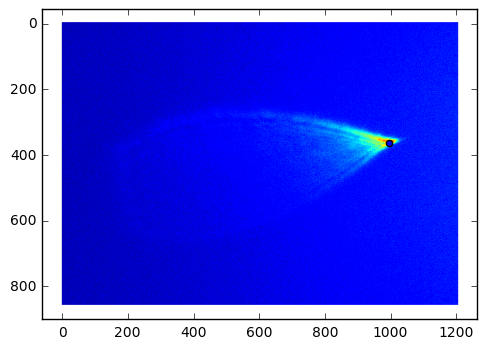

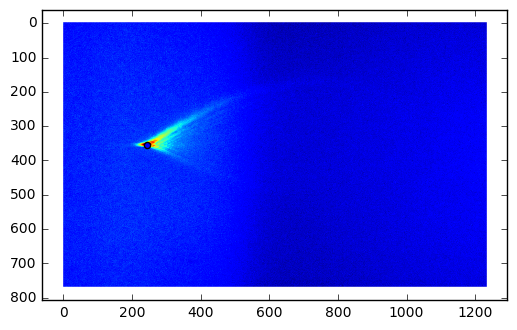

In [3]:
plt.imshow(spotA_green)
plt.scatter(spotA_center[1], spotA_center[0])
plt.show()

plt.imshow(spotB_green)
plt.scatter(spotB_center[1], spotB_center[0])
plt.show()

In [4]:
spot_width = 25.0
spot_height = 20.0

spot_rect = np.array([-spot_height/2, -spot_width/2, spot_height/2, spot_width/2])
crop_center = np.array([spot_height/2, spot_width/2])

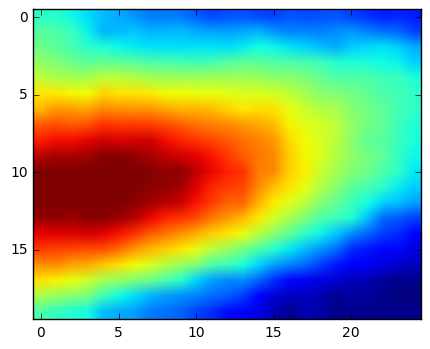

In [5]:
spotA_rect = np.zeros(4)
spotA_displacement = np.array([0, 10])

spotA_rect[0:2] = spotA_center + spot_rect[0:2] + spotA_displacement
spotA_rect[2:4] = spotA_center + spot_rect[2:4] + spotA_displacement

x1, y1, x2, y2 = [int(x) for x in spotA_rect]

spotA_crop = spotA_green[x1:x2, y1:y2]

plt.imshow(spotA_crop)
plt.show()

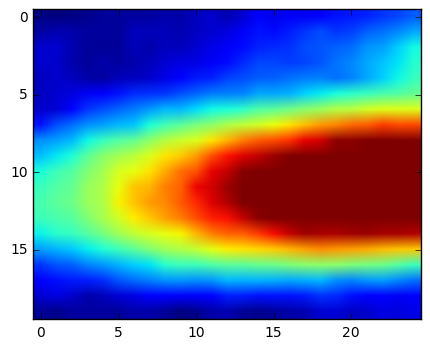

In [6]:
spotB_rect = np.zeros(4)
spotB_displacement = np.array([0, -10])

spotB_rect[0:2] = spotB_center + spot_rect[0:2] + spotB_displacement
spotB_rect[2:4] = spotB_center + spot_rect[2:4] + spotB_displacement

x1, y1, x2, y2 = [int(x) for x in spotB_rect]

spotB_crop = spotB_green[x1:x2, y1:y2]

plt.imshow(spotB_crop)
plt.show()

In [7]:
def clamped_gaussian(height, center_x, center_y, width_x, width_y, theta, noiselevel):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    theta = float(theta)
    return lambda x,y: np.minimum(1.0, height*np.exp(
                -( ( ( np.cos(theta)*(center_x-x) - np.sin(theta)*(center_y-y) ) / width_x)**2
                  +( ( np.sin(theta)*(center_x-x) + np.cos(theta)*(center_y-y) ) / width_y)**2
                 ) / 2 ) + noiselevel)

def fit_clamped_gaussian(data, initial_params):
    """Returns (height, x, y, width, noiselevel)
    the gaussian parameters of a 2D distribution found by a fit"""
    errorfunction = lambda p: np.ravel(clamped_gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    try:
        p, success = scipy.optimize.leastsq(errorfunction, initial_params)
        return p
    except Exception as e:
        print("Fitting failed: " + repr(e))
        return np.array(initial_params)


In [17]:
def fit_spot_crop(spot_crop_linear, crop_center, spot_displacement):
    spot_center_guess = crop_center - spot_displacement
    initial_params = np.array([2.0, *spot_center_guess, *crop_center, 0.0, 0.0])
    fit_params = fit_clamped_gaussian(spot_crop_linear, initial_params)
    
    return fit_params

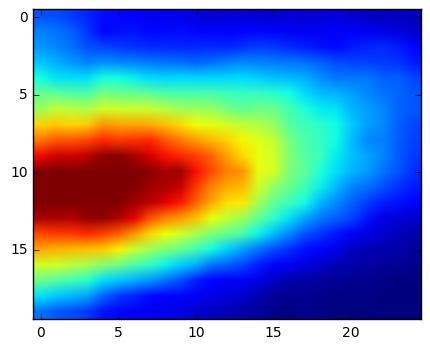

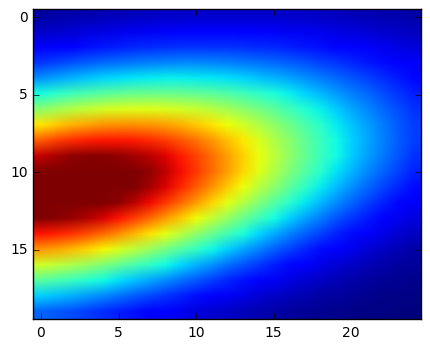

In [18]:
spotA_crop_linear = DataProcessing.uint8_color_img_to_linear_intensity_img(spotA_crop)

fit_paramsA = fit_spot_crop(spotA_crop_linear, crop_center, spotA_displacement)

plt.imshow(spotA_crop_linear)
plt.show()
plt.imshow(clamped_gaussian(*fit_paramsA)(*np.indices(spotA_crop_linear.shape)))
plt.show()

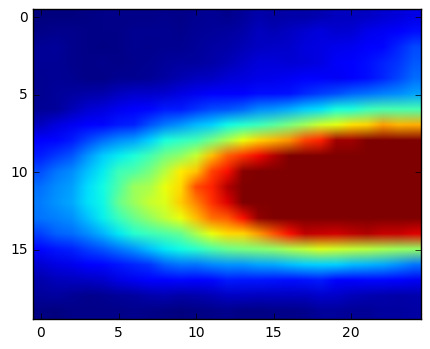

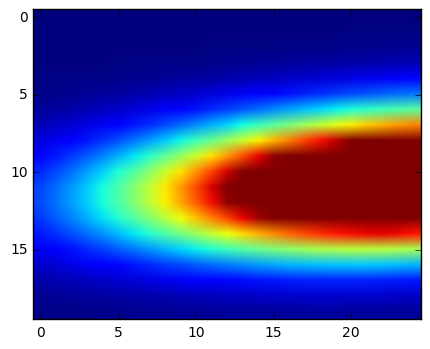

In [19]:
spotB_crop_linear = DataProcessing.uint8_color_img_to_linear_intensity_img(spotB_crop)

fit_paramsB = fit_spot_crop(spotB_crop_linear, crop_center, spotB_displacement)

plt.imshow(spotB_crop_linear)
plt.show()
plt.imshow(clamped_gaussian(*fit_paramsB)(*np.indices(spotB_crop_linear.shape)))
plt.show()

In [20]:
fit_paramsB

array([  1.64304174,  10.66267358,  24.14545152,   2.8360594 ,
        11.59209285,  -0.04980461,   0.07016483])

In [22]:
fit_paramsA

array([  1.04768246,  11.03950847,   1.60097307,   4.33088182,
        12.16620735,  -0.17714072,   0.03594052])